Project for the course in effective-programming-practices for economists | Winter 21/22, M.Sc. Economics, Bonn University |
<br><br>
the project is created by:<br><br>
[Daniel Nogues Kollert](https://github.com/johqniel) (Student-ID: 3055726)

________

# Benchmarking Global Optimization Algorithms 

___

This notebook documentes the work done by myself within the final project for the "OSE - scientific computing for economists" class that was held by Prof. Eisenhauer in the Wintersemester 21/22. The project was handed in by two students but only one (Daniel Nogues Kollert) is handing in his work for grading to the "effective programming practises for economists" to. They just decided to extend their work a little bit by missing pieces that were done by their co-author. The work presented in this notebook is inpired to a great extent by the following Articles:

> Arnoud, Antoine and Guvenen, Fatih and Kleineberg, Tatjana, Benchmarking Global Optimizers (October 2019)<br><br>

> Beiranvand, V., Hare, W. & Lucet, Y. Best practices for comparing optimization algorithms. Optim Eng 18, 815–848 (2017)<br><br>

> Bartz-Beielstein, T. et al. Benchmarking in Optimization: Best Practice and Open Issues

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Benchmarking-Global-Optimization-Algorithms" data-toc-modified-id="Benchmarking-Global-Optimization-Algorithms-1">Benchmarking Global Optimization Algorithms

</a></span></li><li><span><a href="#0.-Introduction" data-toc-modified-id="0.-Goal-of-our-project-2">0. Goal of our project

</a></span></li><li><span><a href="#1.-Global-Optimization" data-toc-modified-id="1.-Global-Optimization-3">1. What is "global optimization"?

</a></span><ul class="toc-item"><li><span><a href="#1.1-key-concepts" data-toc-modified-id="1.1-key-concepts">1.1 Other concepts important to follow our study

</a></span></li></ul></li><li><span><a href="#2.-Reproducability" data-toc-modified-id="1.-Reproducability">2. Reproducibility

</a></span></li><li><span><a href="#3.-Optimization-Algorithms" data-toc-modified-id="3.-Optimization-Algorithms-4">3. Some optimization Algorithms we implemeted.

</a></span><ul class="toc-item"><li><span><a href="#3.1-Gradient-Based-Algorithms" data-toc-modified-id="3.1-Gradient-Based-Algorithms-4.1">3.1 Gradient based algorithm

</a></span></li><li><span><a href="#3.2-Derivative-Free-Algorithms" data-toc-modified-id="3.2-Derivative-Free-Algorithms-4.2">3.2 Derivative-free algorithms

</a></span></li></ul></li><li><span><a href="#4.-Test-Problems" data-toc-modified-id="4.-Test-Problems-5">4. Test Problems


</a></span></li></ul></li><li><span><a href="#5.-Benchmarking-Procedure" data-toc-modified-id="5.-Benchmarking-Procedure-6">5. Benchmarking Procedure

</a></span><ul class="toc-item"><li><span><a href="#5.1-general-setup-of-our-benchmark" data-toc-modified-id="5.1-general-setup-of-our-benchmark">5.1 General set-up of our benchmark

</a></span></li><li><span><a href="#5.2-Testing-of-optimization-Algorithms" data-toc-modified-id="5.2-Testing-of-optimization-Algorithms">5.2 Testing of optimization Algorithms 

</a></span></li><li><span><a href="#5.3-Algorithm-Performance-Measures" data-toc-modified-id="5.3-Algorithm-Performance-Measures-6.3">5.3 Design choices



</a></span></li></ul></li><li><span><a href="#6.-Results" data-toc-modified-id="6.-Results-7">6. Results

</a></span></li></ul></li><li><span><a href="#7.-Conclusion" data-toc-modified-id="10.-Conclusion-14">7. Conclusion

</a></span></li><li><span><a href="#References" data-toc-modified-id="References-15">References</a></span></li></ul></div>

In [7]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt


---
# 0. Goal of our project 
---

The goal of our project was to benchmark multiple global optimization algorithms from the **NLOPT** libary. This part of our work mostly replicates work done in Gueven et al. (2019). We wanted to extend on their article by implementing our own optimization algorithms and compare them to the ones provided by the python libaries. Sadly we struggled to implement them flexible and robust enough to run the benchmarks designed for the algorithms from the **NLOPT** libary. In a future project that extend our work one could try to further improve the two algorithms we implemented but for now we decided to benchmark them with a second benchmark routine. While we can thus not compare them directly to the algorithms from the **NLOPT** libary we still get to compare the two to one another. The work we submitted to the OSE class is documented in the File student_project.ipynb . In this notebook we will mostly describe the work done in the skripts newton_based_optimization.py, nelder_mead_based_optimization.py, test_optimization.py, callable_algorithms.py and benchmark_routine.py since these were all done exclusivly by me and illustrate well how I applied routines learned in the EPPE class such as using Git, pytest and docstrings.  

---
# 1. What is "global optimization"? 
---

Global optimization is a term that includes many different mathematical problems of varying complexity and abstraction. Within this notebook though we want to restrict ourselfes to the unconstrained optimization of real valued functions whose domain is a open ball within $\R^n$. We make these restrictions because the two optimization algorithms we implemented can not yet deal with any constrains and do only take open balls as domains. Clearly these restrictions make the algorithms inpractical for professional use. Since in the benchmark methodology outlined in Guvenen et al. (2019) they controll the functions to be optimized, these restrictions are reasonable. Mathematically the problems we consider can be described by the following: 

Let $f\colon \R^n \to \R$ be a real valued function, $r\in\R_+$ a positive real number and $\mathbf{x}_\text{d}$ be a point in $\R^n$ such that:

$$ \underset{|x-\mathbf{x}_\text{d}|\leq r}{\text{argmin}}(f) \in \text{B}_r(\mathbf{x}_\text{d}).$$

Here $\text{B}_r(\mathbf{x}_\text{d})$ denotes the open circle with radius $r$ around $\mathbf{x}_\text{d}$.

Then the algorithms should find: 

$$\underset{|x-\mathbf{x}_\text{d}|\leq r}{\text{argmin}}(f).$$

Since one of the two optimization algorithms we implemented relies on first and second derivatives we assume furthermore that $f$ is twice continuously differentiable. 

---
## 1.1 Other concepts important to follow our study
---

We want to give a brief  overview over a view key-words that we are going to use in the following

1. **computational budget:** The computational budget is a measure that we pass to an optimization algorithm. The optimization algorithm is supposed to use at most this many evaluations of the function (or its derivative) to find a candidate for the optimizer.

2. **optimizer:** We are going to refer to the point that optimizes a function $f$ as its optimizer.

3. **x-/y-tolerance:** By tolerance we refer to the treshhold that controlls when the optimization algorithms stop. All the optimization algorithms we benchmark compute candidates fo the optimizer iterativly. Once two consecutive candidates are closer than the x-tolerance, or the respective function values are closer than the y-tolerance the iteration stopps.


---
# 2. Reproducibility 
---

In order to ensure full reproducibility of our project, we have set up a continous integration environment using Github Actions which can be checked by clicking on the badge shown below:

[![Continuous Integration](https://github.com/OpenSourceEconomics/ose-scientific-computing-course-wirecard/actions/workflows/ci.yml/badge.svg)](https://github.com/OpenSourceEconomics/ose-scientific-computing-course-wirecard/actions/workflows/ci.yml)

Also we used seeds whenever we called algorithms that create random inputs. Thus also the results of the optimization algorithms that rely on randomnes are reproducible.

---
# 3. Some optimization algorithms we implemented
---

We implemented two optimization algorithms. First we implemented an algorithm that relies on the Newton-Method an algorithm that can find roots of continuously differentiable functions. All the optimization algorithms we used for the benchmark described in theis assignment can be found in the file callable_algorithms.py. For each algorithm we implemented two versions. One that starts from one point and does a local search. The other versions work as follows:

1. Define the *sample size* $=\colon s$ and the *number of candidates* $=\colon n$ and the domain in which the algorithms should search for the optimizer
2. Evaluate the function value of $s$ many random selected points within the domain. Take the $n$ points with the smallest function value and run a local search from there. Safe the result of the local search in an array $A$.
3. Return the point in $A$ with the lowest function value.

The algorithms that follow the steps 1-3. have the prefix *smart_* in their name in the File callable_algorithms.py. In the following we are going to give a detailed description of the local search algorithms we implemented:

---
## 3.1 Gradient based algorithm
---
The algorithm we designed relies on the following mathematical results: 


- A continuously differentiable function has a critical point wherever it has global minimum. 
- If the newton method applied to the continuously differentiable function $f'$ converges to a point $x$ this point is a root of $f'$.


By one we get that the set of critical points of a function is a set of candidates for the global minimum of a function. Once we have the set of critical points of $f$ within its domain we can simply take the smallest and have a good guess for the global extremum. Two provides us with a strategy to find these critical points. We can run the newton method from different starting points within the domain. Each time it converges we get a candidate that we can add to our list of candidates. 

We will not provide pseudo-code for the newton method but a verbal explication: It aims to find the roots of a function. We use the fact that the gradients of a function $\nabla f (\mathbf{x})$ tell us whether we are moving up or down if we move in the direction of $\mathbf{x}$. Thus we can use the gradient as source of information about the curvature of the function. We can start at some point $\mathbf{x_n}$ and solve in each iteration for the direction $\mathbf{y}$ with the steepest slope. In our next iteration we then consider 

$$\mathbf{x_{n+1}}:= \mathbf{x_n} + \epsilon \cdot \mathbf{y},$$ 

where $\epsilon$ is some small number. Though this approach is very intuitive it comes with a few drawbacks. For example it is not easy to implement and costly since it requieres solving linear equations. Furthermore as explained before gradient based routines fail at optimizing discrete functions or functions with discontinuity points. 

---
## 3.2 Derivative-free algorithm
---

As the name suggest this class comprises all sorts of optimization algorithms that do not use derivatives of the function to be optimized. It is difficult to give an general idea how it works, since there are many different approaches. An interesting pattern is that often times these algorithms are inspired by nature or other real life phenomena. For example there is an optimization algorithm inspired by imperialistic competition (E. Atashpaz-Gargari and C. Lucas, 2007) and discrete optimization algorithms are inspired by the behaviour of bees (D.T. Pham, 2005) and ants (A. Colorni, M. Dorigo and V. Maniezzo 1991).

A well known gradient free algorithm for non discrete functions is the nelder-mead algorithm. It simulates a simplex that moves around the graph of the function until it finds a candidate for a global optimum. We implemented a version of this algorithm. It is way less intuitive than the Newton-Method and thus we are not providing pseudo code because it would not be more insightfull than the commented python-code. We still provide a brief overview of it's key ideas:

**NELDER-MEAD SIMPLEX ALGORITHM**

The Nelder-Mead-method (Nelder, Mead 1965) is the second optimization algorithm that we implemented ourselfes. It generated a simplex around the starting point and then checks how its verticies are horizontally distributed on the surface of the function to be optimized. Depending on how they are the simplex wanders arounds the function by reflecting its highest verticy contracting the highest verticy inside of the simplex or shrinking the whole symplex towards the lowest verticy of the simplex.

**BOBYQA ALGORITHM**

The BOBYQA-algorithm is an optiization algorithm provided by the **NLOPT**-libary that performed especially well in our Benchmark that we submitted for the OSE-assignment. It also uses no derivatives and we are going to use it to classify the performance in the Benchmark of our implementeation of the Nelder-Mead algorithm.



---
# 4. Test Problems
---

In order to test the algorithms we implemented we needed to select real valued functions to be optimized. To test the algorithms from the **NLOPT** libary we selected established testfunctions that are challenging to optimize. According to Guvenen et al. (2019) 4 such problems are given by the following: 

1. Griewank Function 
2. Rastrigin Function 
3. Rosenbrock Function
4. Levi Function  

For the analysis of the **NLOPT**-libaries algorithms we used these four and three other testfunctions. For our naive implementations of the nelder-mead method and the newton-based optimization we focused on the first three. For these three we provide a brief overview over their definition and apperance. 


---
## 4.1 Griewank Function
---

The Griewank function, first introduced by Griewank (1981) has been employed as test function for global optimization algorithms in many papers. In n- dimensions is defined by the following expression:<br><br>

\begin{align*}
    f(x)=\sum_{i=1}^n\frac{x_i^2}{a}-\prod_{i=1}^n\cos(\frac{x_i}{\sqrt{i}})+2.
\end{align*}

Here $n$ is the number of dimensions. We will choose $a=200$ as described in Guvenen et al. (2019). The Griewank function has many widespread local minima, which have a regular distribution along the domain. The complexity is shown in the following plot. The domain of interest is defined by the hypercube $x\in[-100,100]^n$. In the optimization we consider the circle with radius 100. The global minimum of this function is at $x=(0,...,0)$ with function value $f(0,...,0)=1$. We have plotted the Griewank function for $n=2$ (two dimensional function):

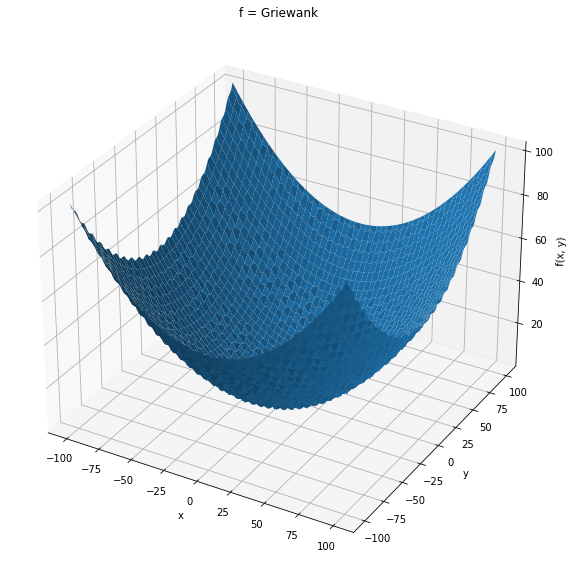

In [8]:
from auxiliary.testing import plot_test_function
from auxiliary.functions import griewank

plot_test_function((-100,100),griewank,"Griewank")

---
## 4.2 Rastrigin Function
---


There exist different ways to define the Rastrigin function. We will use the functional form proposed by Gueven et al. (2019). For $x\in\R^n$ the output is given by: 

\begin{align*}
    f(x)=A\cdot n+\sum_{i=1}^n[x_i^2-A\cos(2\pi x_i)]+1.
\end{align*}


The domain considered usually in benchmarks is $x\in [-5.12,5.12]^n$. The global minimum is located at $x=(0,...,0)$ with function value $f(0,...,0)=1$. Similar to the Griewank function it is bowlshaped with many local minima. Compared to the Griewank function its local minima are more pronounced as one can see in the following plot:

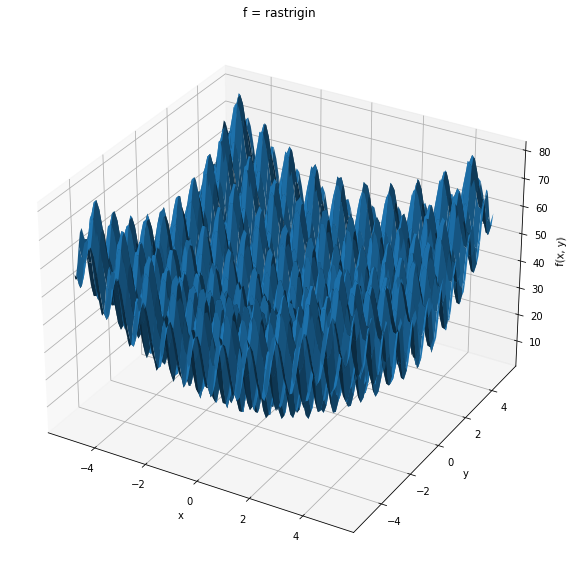

In [9]:
from auxiliary.functions import rastrigin

plot_test_function((-5.12,5.12),rastrigin, "rastrigin")

---
## 4.4 Rosenbrock Function
---

While the Griewank and Rastrigin function challenge the optimization algorithms with many local minima which they can mistake for the global minimum the global minimum of the Rosenbrock function lies within a huge flat valley. In $n$-dimensions it is defined as
\begin{align*}
f(x)=\sum_{i=1}^{n-1}[100(x_{i+1}-x_i^2)^2+(1-x_i)^2]+1.
\end{align*}
We consider the domain $x\in[-100,100]^n$. The global minimum is given by $x=(1,...,1)$ with function value $f(1,...,1)=1$. The following plot illustrates well the valley in which the global optimum of the 2-dimensional rosenbrock function lies: 

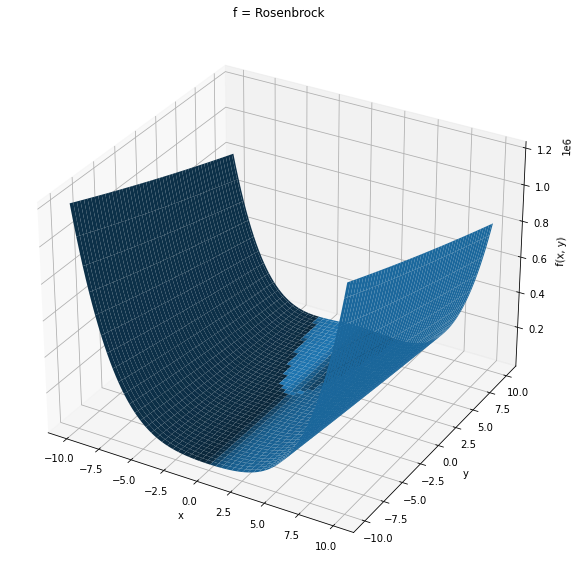

In [10]:
from auxiliary.functions import rosenbrock

plot_test_function((-10,10), rosenbrock, "Rosenbrock")

---
# 5. Benchmarking Procedure
---

Most benchmarking studies have a clear underlying reason, why the study is conducted. For example in Guvenen et al. (2019) the reason for benchmarking has been the introduction of a new optimization routine (the TIK TAK) algorithm. The primary goal of this study has been to show the value of this novel algorithm compared to more classical methods. 

Our primary goals for the replication of their study were to:

1. Gather experience on how to design and implement a benchmarking study 
2. Gather experience in designing and implementing flexible optimization algorithnms
3. Find out how well our self-implemented optimization algorithms perform compared to the **NLOPT** libary

In the following chapters we are going to walk through different steps we followed to reach our third goal.

---
## 5.1 Generall set-up of our Benchmark
---

While benchmarking the optimization algorithms we obtained from libaries we realized that the naive implementations of both the nelder-mead method as well as the newton based do not perform fast and reliable enough for the benchmarking procedure we designed for the **NLOPT** libaries algorithms. The benchmarking would not finish in a reasonable time and both algorithms are very likely to loose themselves in local minima. Thus they were only identifying the correct minimum if they either start the optimization very close to the actual global minimum or if the function to be optimized has only one local (and global) minimum. Thus we decided to exclude them from the Benchmarking for now. Still we learned a lot about the implementation of optimization algorithms and learned on what to improve on for future optimization projects. 

While polishing our project for the assignment for the EPPE class, we implemented a simple benchmarking routine that allows us to benchmark at least one of the two algorithms we implemented: the nelder-mead based optimization. We ran this Benchmark also on some of the algorithms from the **NLOPT** libary to compare the performance of our optimization algorithm to the others. The results will be disscussed in the end of this notebook. 

While designing our Benchmark we followed the design choices proposed by Gueven et al. (2019). It can be summarized as follows:

1. Pick a test-function out of the functions we introduced above
2. Pick an algorithm out of the algorithms we introduced above
3. Define number of optimizations $n$ to be run for each computational budget
4. Define a set of computational-budgets such as $C = \{1000,2000,..., 10000\}
5. For each computational-budget and algorithm run $n$ optimizations

During step 5 we collect the following data: 

1. The time it took the algorithm to find a candidate for an optimizer
2. Wether the candidate is actually the optimizer (up to a certain tolerance)

Averaging these measures over all optimizations with a given computational budget we can discuss and compare how well the optimization algorithms perform. In addition to the two measures we described above, one add without much effort further measures such as:

1. The accuaracy, i.e. the absolute distance between the proposed optimizer and the actual optimizer
2.  

---
## 5.2 Testing of optimization Algorithms
---

Once we figured out which inputs the optimization algorithms we designed a test routine with pytest to verify wether the functions we use for the optimization work properly. All the tests are provided in the file called test_optimization.py (in the auxiliarry foulder) in which we test the two algorithms with 6 functions. The first three are functions with only a few local minima. Both algorithms can also find the optimum of the rosenbrock, rastrigin and griewank function, if they start the iteration close enough to the actual optimum. The first three functions are given by the following equations: 

\begin{align*}
    &\bullet \hspace{0.3cm}\mathbf{x} \mapsto 20 \cdot (x_1 + x_2)^2 + x_2^4 + 1, \\
    &\bullet \hspace{0.3cm}\mathbf{x}\mapsto\frac{1}{200} \cdot (x_1 + 1)^2 \cdot \{\text{cos}(x_2) + 1\} + x_2^2,\\
    &\bullet \hspace{0.3cm}\mathbf{x}\mapsto\frac{1}{800}\cdot(x_1 - 6)^4 \cdot \{\text{sin}(x_2) + 3\} + x_2^4.
\end{align*}

All these functions are bowlshaped and have minima at: $(0,0)^T,(-1,0)^T,(6,0)^T \in \mathbb{R}^2$ respectively. Our test routines test_call_nelder_mead and test_old_newton_opti are designed such that they through an error **iff** one of the two optimization algorithms does not find the correct optimum for one of the six functions.

In [11]:
from auxiliary.test_optimization import test_call_nelder_mead_method
from auxiliary.test_optimization import test_old_newton_opti

test_call_nelder_mead_method()
test_old_newton_opti()

Though this is only a small selection of test functions it shows that for easy problems the optimization algorithms we implemented work properly. Alternativly the tests can also be run by pytest. 

---
## 5.3 Design choices for the benchmark 
---

We picked the following default values for our benchmark:

- **x-/y-tolerance:** $10^{-6}$
- **sample size:** 100.
- **number of candidates:** 5.
- **number of optimizations:** 10.

The first three measures affect how the algorithms perform. For now we are going to stick with the proposed values, but with the help of our benchmark routine one could figure out which values optimize the average speed or success rate for a given computational budget. The last measure defines how many optimizations the benchmark runs for each computational budget. To keep the computation time reasonable we decided to pick a smaller number than 100, which was the amount of optimizations used in the original study. 




---
# 6. Results
---

In the following cell we run the benchmark for all the testfunctions and the two algorithms.

Benchmark  1  out of  2 done.
Benchmark  1  out of  2 done.

 First set done 

Benchmark  1  out of  2 done.
Benchmark  1  out of  2 done.

 Second set done 

Benchmark  1  out of  2 done.
Benchmark  1  out of  2 done.

 Third set done 



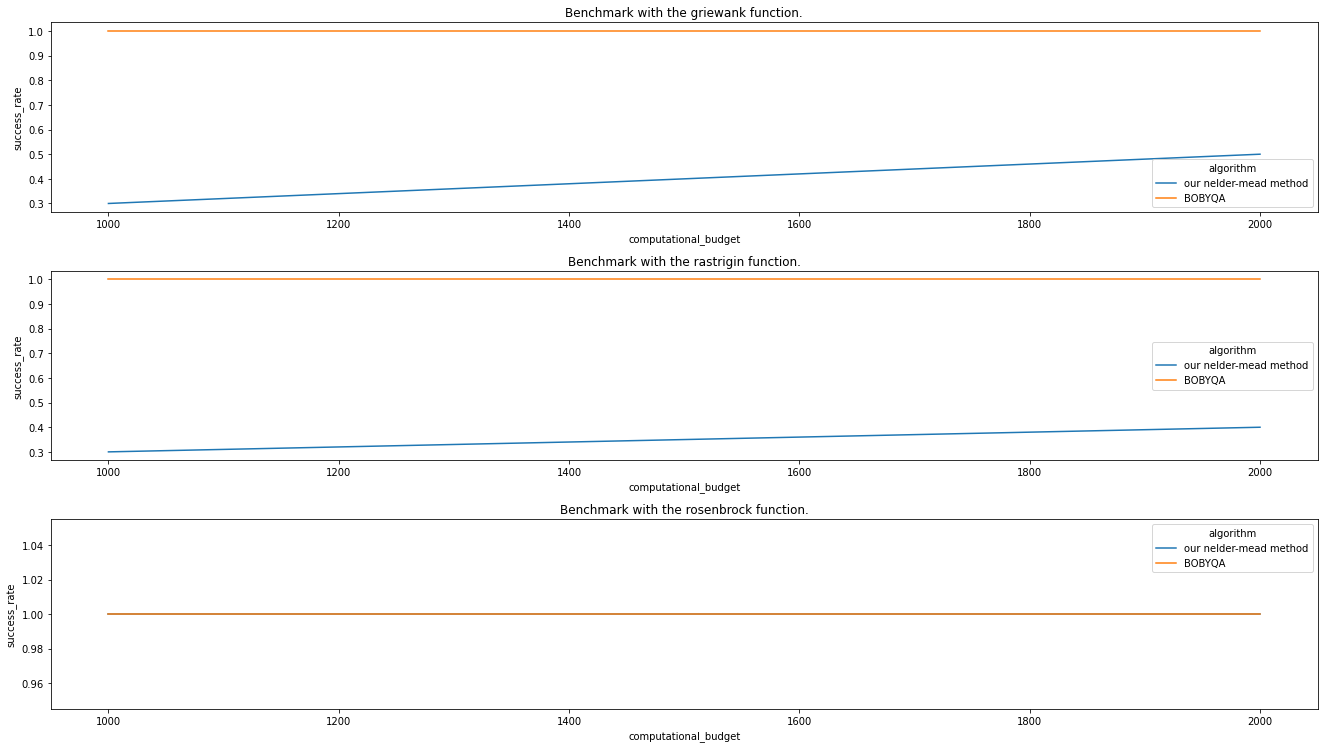

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from auxiliary.callable_algorithms import(
    global_nelder_mead_method,
    global_optimization_BOBYQA
)
from auxiliary.functions import(
    griewank,
    rastrigin,
    rosenbrock,
    levi_no_13
)
from auxiliary.benchmark_routine import(
    run_smart_benchmark
)


# Set al variables relevant for the benchmark
computational_budgets = [1000,2000]
number_of_candidates = 5
sample_size = 100
number_of_optimizations = 10
dimension = 2
domain_center = [0,0]
domain_radius = 100
names_of_functions = ["griewank","rastrigin", "rosenbrock"]

# run benchmarks with the griewank function
df_nelder_mead_griewank = run_smart_benchmark(global_nelder_mead_method,griewank,[0,0],computational_budgets,domain_center,domain_radius,dimension,number_of_optimizations,algorithm_name = "our nelder-mead method",test_function_name="griewank")
df_BOBYQA_griewank = run_smart_benchmark(global_optimization_BOBYQA,griewank,[0,0],computational_budgets,domain_center,domain_radius,dimension,number_of_optimizations,algorithm_name = "BOBYQA",test_function_name="griewank")
df_griewank = pd.concat([df_nelder_mead_griewank,df_BOBYQA_griewank])

print("\n First set done \n")


# run benchmarks with the rastrigin function
df_nelder_mead_rastrigin = run_smart_benchmark(global_nelder_mead_method,rastrigin,[0,0],computational_budgets,domain_center,domain_radius,dimension,number_of_optimizations,algorithm_name = "our nelder-mead method",test_function_name="rastrigin")
df_BOBYQA_rastrigin = run_smart_benchmark(global_optimization_BOBYQA,rastrigin,[0,0],computational_budgets,domain_center,domain_radius,dimension,number_of_optimizations,algorithm_name = "BOBYQA",test_function_name="rastrigin")
df_rastrigin = pd.concat([df_nelder_mead_rastrigin,df_BOBYQA_rastrigin])

print("\n Second set done \n")


# run benchmarks with the rosenbrock function
df_nelder_mead_rosenbrock = run_smart_benchmark(global_nelder_mead_method,rosenbrock,[1,1],computational_budgets,domain_center,domain_radius,dimension,number_of_optimizations,algorithm_name = "our nelder-mead method",test_function_name="rosenbrock")
df_BOBYQA_rosenbrock = run_smart_benchmark(global_optimization_BOBYQA,rosenbrock,[1,1],computational_budgets,domain_center,domain_radius,dimension,number_of_optimizations,algorithm_name = "BOBYQA",test_function_name="rosenbrock")
df_rosenbrock = pd.concat([df_nelder_mead_rosenbrock,df_BOBYQA_rosenbrock])

print("\n Third set done \n")

# concatinate data
df = pd.concat([df_griewank,df_rastrigin,df_rosenbrock])
 

# plot data
fig, axes = plt.subplots(ncols=1, nrows=3)
fig.set_size_inches(18.5, 10.5, forward=True)


for function, ax in zip(names_of_functions, axes.flat):
    sns.lineplot(ax = ax, x="computational_budget", y="success_rate", hue="algorithm", data=df.loc[df['test_function']==function])
    ax.set_title("Benchmark with the " + function + " function.")
plt.tight_layout()
plt.show()

Looking at the graphs it becomes very clear, that the BOBYQA-algorithm outperforms our nelder-mead method by such a wide margin for the griewank and rastrigin function that the latter can not be considered in any sense usefull compared to the BOBYQA-algorithm. With a computational Budget of just 1000 the BOBYQA already reaches a success rate very close to 1 for all considered testfunctions, while our nelder-mead method doesnt reach a succes rate above 0.95 even with a computational budget of 20000 for the griewank and rastrigin function. This is most likely the case because the our nelder-mead method misidentifies some of the many local minima of the griewank and rastrigin function for the global optimum. This hypothesis is supported by the fact that for the rosenbrock function that has only one local optimum our nelder-mead method finds the optimum with similar accuracy like the BOBYQA-algorithm.

---
# 10. Conclusion
---

---
#  References
---

- Pardalos, Panos M.; Romeijn, Edwin H., "Handbook of Global Optimization", Springer Science and Business Media, 2013
- Liberti, Leo. “Introduction to Global Optimization.”, Computer Science, (2006)
- Ali, Montaz, Charoenchai Khompatraporn, and Zelda B. Zabinsky, “A Numerical
  Evaluation of Several Stochastic Algorithms on Selected Continuous Global Optimization
  Test Problems,” Journal of Global Optimization, 2005, 31, 635–672.
- Surjanovic, S. & Bingham, D. (2013). Virtual Library of Simulation Experiments: Test Functions and Datasets.     Retrieved January 4, 2022, from http://www.sfu.ca/~ssurjano.
- Jamil, M., & Yang, X. (2013). A literature survey of benchmark functions for global optimisation problems. Int. J. Math. Model. Numer. Optimisation, 4, 150-194.
- Griewank A.O. (1981), Generalized descent for global optimization,Journal of Optimization Theoryand Applications34, 11-39
- Locatelli, M. A Note on the Griewank Test Function. Journal of Global Optimization 25, 169–174 (2003). https://doi.org/10.1023/A:1021956306041
- Rosenbrock, H.H. (1960). "An automatic method for finding the greatest or least value of a function". The Computer Journal. 3 (3): 175–184. doi:10.1093/comjnl/3.3.175. ISSN 0010-4620.
- J. J. More', B. S. Garbow, and K. E. Hillstrom. Testing unconstrained optimization
   software. ACM Transactions on Mathematical Software (TOMS),7(1):17{41, March 1981
   
- Steven G. Johnson, The NLopt nonlinear-optimization package [link](http://github.com/stevengj/nlopt)
- Dolan, Elizabeth D. and Jorge Moré, “Benchmarking Optimization Software with Performance
  Profiles,” Mathematical Programming, 2002, 91 (2), 201–213.
- Moré, Jorge J. and Stefan M. Wild, “Benchmarking Derivative-Free Optimization Algorithms,”
  SIAM Journal on Optimization, 2009, 20 (1), 172–191.

- Price, Wyn L., “A controlled random search procedure for global optimisation,” The Computer
  Journal, 1977, 20 (4), 367–370.
  
- Kaelo, P. and M. M. Ali, “Some variants of the controlled random search algorithm for global
  optimization,” Journal of Optimization Theory and Applications, 2006, 130 (2), 253–264.
  
- Runarsson, Thomas P. and Xin Yao, “Stochastic ranking for constrained evolutionary
  optimization,” IEEE Transactions on evolutionary computation, 2000, 4 (3), 284–294.
  
- Rinnooy Kan, Alexander and G. T. Timmer, “Stochastic Global Optimization Methods,
  Part I, Clustering Methods,” Mathematic Programming, 1987, 39 (27-56).
  
- Silva-Santos, Carlos Henrique, Marcos Sergio Goncalves, and Hugo Enrique
  Hernandez-Figueroa, “Designing novel photonic devices by bio-inspired computing,” IEEE
  Photonics Technology Letters, 2010, 22 (15), 1177–1179.

- E. Atashpaz-Gargari and C. Lucas, "Imperialist competitive algorithm: An algorithm for optimization inspired by imperialistic competition," 2007 IEEE Congress on   
  Evolutionary Computation, 2007, pp. 4661-4667, doi: 10.1109/CEC.2007.4425083.

- Alberto Colorni, Marco Dorigo and Vittorio Maniezzo. "Distributed optimization by ant colonies." Proceedings of the first European conference on artificial life.    
  Vol.142. 1991
  
- Markowitz, H. (1952), PORTFOLIO SELECTION*. The Journal of Finance, 7: 77-91. https://doi.org/10.1111/j.1540-6261.1952.tb01525.x

- Eric Zivot Lecture Materials [see here](https://faculty.washington.edu/ezivot/classes.htm)

- Liu, Scott and Xu, Rong, The Effects of Risk Aversion on Optimization, February 2010 (February 22, 2010). MSCI Barra Research Paper No. 2010-06, Available at SSRN: https://ssrn.com/abstract=1601412 or http://dx.doi.org/10.2139/ssrn.1601412
